In [1]:
import re
from itertools import chain, product
import pynini as pn

In [2]:
PHONE_TABLE = """
sil spn 
a aj aw 
o ow
ə ɥ 
e ej  
i io
j w u y
p pʰ m f
t tʰ n l
k kʰ x 
tɕ tɕʰ  
ʈʂ ʈʂʰ ʂ ʐ ʐ̩
ts tsʰ ɕ
z z̩ s 
ŋ ŋ̍ ɻ ʔ
"""

In [3]:
## Confusingly, the ilabel for fst is 1-based, but log-like matrix is 0-based
## The code in Kaldi (decodable-matrix.h:240) will offset the ilabel by 1 for us.
phone_list = PHONE_TABLE.strip().replace("\n", " ").split()
phone2id = {x: i+1 for i, x in enumerate(phone_list)}
phone2id

{'sil': 1,
 'spn': 2,
 'a': 3,
 'aj': 4,
 'aw': 5,
 'o': 6,
 'ow': 7,
 'ə': 8,
 'ɥ': 9,
 'e': 10,
 'ej': 11,
 'i': 12,
 'io': 13,
 'j': 14,
 'w': 15,
 'u': 16,
 'y': 17,
 'p': 18,
 'pʰ': 19,
 'm': 20,
 'f': 21,
 't': 22,
 'tʰ': 23,
 'n': 24,
 'l': 25,
 'k': 26,
 'kʰ': 27,
 'x': 28,
 'tɕ': 29,
 'tɕʰ': 30,
 'ʈʂ': 31,
 'ʈʂʰ': 32,
 'ʂ': 33,
 'ʐ': 34,
 'ʐ̩': 35,
 'ts': 36,
 'tsʰ': 37,
 'ɕ': 38,
 'z': 39,
 'z̩': 40,
 's': 41,
 'ŋ': 42,
 'ŋ̍': 43,
 'ɻ': 44,
 'ʔ': 45}

In [4]:
# phone_seq = "ɕ e˥˩ ts aj˥˩".split()
phone_seq = "ɕ j e˥˩ n ts aj˥˩".split()
phone_seq = [re.sub("[\u02e5-\u02e9]+", "", x) for x in phone_seq]

In [5]:
var_table = {
    "e": ["a"],
    "ts": ["ʈʂ"],
    "aj": ["a"]
}
## make variants
linear_seq = phone_seq[:]
phone_seq = [(x, *var_table.get(x, [])) for x in phone_seq]
phone_seq

[('ɕ',), ('j',), ('e', 'a'), ('n',), ('ts', 'ʈʂ'), ('aj', 'a')]

In [6]:
st = pn.SymbolTable()
st.add_symbol("<eps>", 0)
for phone_i, phone_x in enumerate(chain.from_iterable(phone_seq)):
    st.add_symbol(phone_x, phone2id[phone_x])

In [7]:
list(st)

[(0, '<eps>'),
 (38, 'ɕ'),
 (14, 'j'),
 (10, 'e'),
 (3, 'a'),
 (24, 'n'),
 (36, 'ts'),
 (31, 'ʈʂ'),
 (4, 'aj')]

## Build FST

### Linear chain

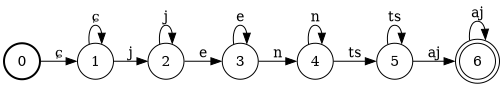

In [10]:
lin_fst = pn.Fst()
lin_fst.add_state()
lin_fst.set_start(0)
lin_fst.set_final(0)
for phone_xs in phone_seq:    
    fstx = pn.accep(phone_xs[0], token_type=st)   
    lin_fst = lin_fst + fstx

# add self-loop
olabel_map = {}  # State -> olabel
for state_i in lin_fst.states():
    for arc_x in lin_fst.arcs(state_i):
        if arc_x.ilabel == 0:
            continue
        arc_cpy = arc_x.copy()
        next_state = arc_cpy.nextstate        
        lin_fst.add_arc(next_state, arc_x)
lin_fst.set_input_symbols(st).optimize()

In [11]:
fst = pn.Fst()
fst.add_state()
fst.set_start(0)
fst.set_final(0)
for phone_xs in phone_seq:    
    var_fst = pn.union(*[pn.accep(x, token_type=st) for x in phone_xs])    
    fst = fst + var_fst

# add self-loop
olabel_map = {}  # State -> olabel
for state_i in fst.states():
    for arc_x in fst.arcs(state_i):
        if arc_x.ilabel == 0:
            continue
        arc_cpy = arc_x.copy()
        next_state = arc_cpy.nextstate        
        fst.add_arc(next_state, arc_x)
        

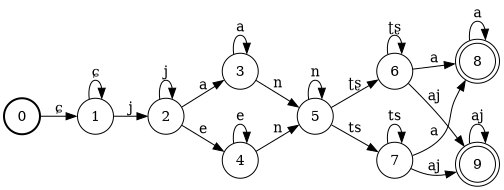

In [12]:
fst.set_input_symbols(st).optimize()

In [13]:
## determine rank
buf = [0]
visited = set()
rank_map = {0: 0}  # State:Int -> Rank:Int

while buf:    
    state_i = buf.pop(0)    
    visited.add(state_i)    
    buf.extend([x.nextstate 
                for x in fst.arcs(state_i)
                if x.nextstate not in visited])    
    
    for arc_x in fst.arcs(state_i):        
        next_state = arc_x.nextstate
        rank_map[next_state] = min(
            rank_map.get(next_state, 9999),
            rank_map[state_i]+1
        )
        
ranked_states = [[] for _ in range(max(rank_map.values())+1)]
for state_i, rank in rank_map.items():
    ranked_states[rank].append(state_i)

In [14]:
rank_map, ranked_states

({0: 0, 1: 1, 2: 2, 3: 3, 4: 3, 5: 4, 6: 5, 7: 5, 8: 6, 9: 6},
 [[0], [1], [2], [3, 4], [5], [6, 7], [8, 9]])

In [15]:
def find_self_loop(arcs, state_i):
    loop = [x.olabel for x in arcs
            if x.nextstate == state_i]    
    return loop[0]
    

In [16]:
## Add skip arcs
n_rank = len(ranked_states)
for skip_dist in range(2, len(ranked_states)-1):    
    for rank_i in range(n_rank - skip_dist):
        rank_j = rank_i + skip_dist        
        start_states = ranked_states[rank_i]
        end_states = ranked_states[rank_j]
        for state_i, state_j in product(start_states, end_states):
            emit_symint = find_self_loop(fst.arcs(state_j), state_j)
            fst.add_arc(state_i, 
                        pn.Arc(emit_symint, emit_symint, 
                        weight=None, nextstate=state_j))

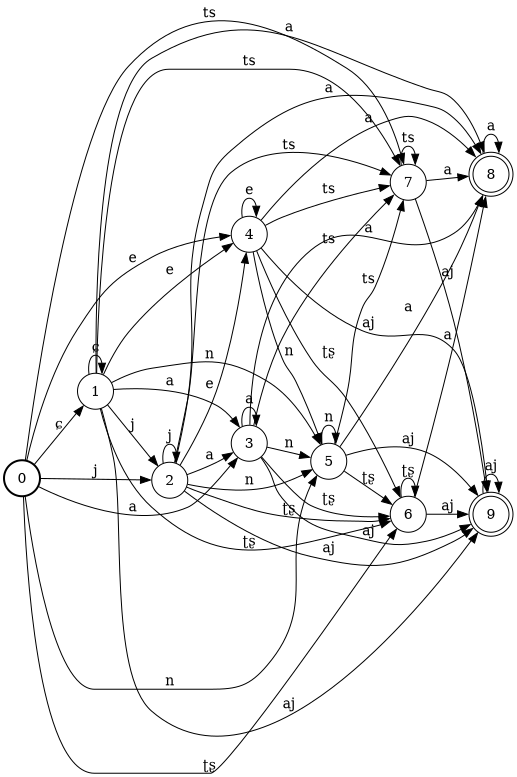

In [17]:
fst

In [19]:
fst.set_input_symbols(None)
fst.write("../../data/fst/xianzai_var.fst")

`765447f90ac93e1b4c80be7fab0d7dbae1e6ef0e  xianzai_var.fst`

In [20]:
!sha1sum ../../data/fst/xianzai_var.fst

765447f90ac93e1b4c80be7fab0d7dbae1e6ef0e  ../../data/fst/xianzai_var.fst
